# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, and transfering of HBR models. 

### Imports

In [1]:
# Need to install graphviz for the graphical model visualization
# %conda install -c conda-forge python-graphviz graphviz

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param2 import make_param, Param
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az
import os
import pymc as pm

plt.rcParams["figure.figsize"] = (5, 5)


# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [4]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [5]:
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

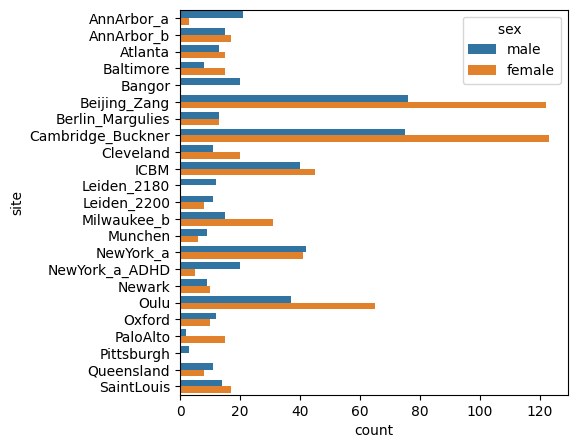

In [6]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

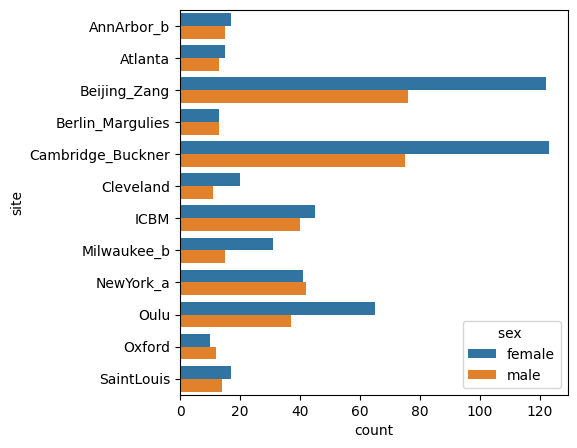

In [7]:
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()


Now we load the data into a `NormData` object. 

In [8]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

We will use 2 sites for transfer (Milwaukee and Oulu) and the rest for training.

In [9]:
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)


We also split the data into train and test sets.

In [10]:
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [11]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a SHASHb likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. 

In [12]:
mu = make_param(
    name="mu",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    intercept=make_param(
        random=True,
        sigma=make_param(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_param(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_param(
    name="sigma",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_param(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)


# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood="Normal",
    mu=mu,
    sigma=sigma,
    nuts_sampler="nutpie",
    init="jitter+adapt_diag",
)

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [13]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [14]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the model
With all our configuration done, we can fit our model on the train data. 

In [15]:
predictions = norm_hbr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,209,0.17,63
,2000,121,0.17,63
,2000,30,0.18,63
,2000,38,0.18,47


Sampling: [y_pred]


Output()

Fitting and predicting model for WM-hypointensities


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,46,0.13,63
,2000,40,0.14,95
,2000,31,0.14,31
,2000,45,0.15,20


Sampling: [y_pred]


Output()

73413 Saving model to resources/hbr/save_dir


BlockingIOError: [Errno 35] Unable to create file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

As we can see, the model is saved to the save_dir specified in the norm_conf. We can inspect that folder to find three subfolders:
- `model`: contains the model and metadata
- `results`: containing csv files with the evaluation results for all response variables
- `plots`: containing qq plots and centile plots for each response variable

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

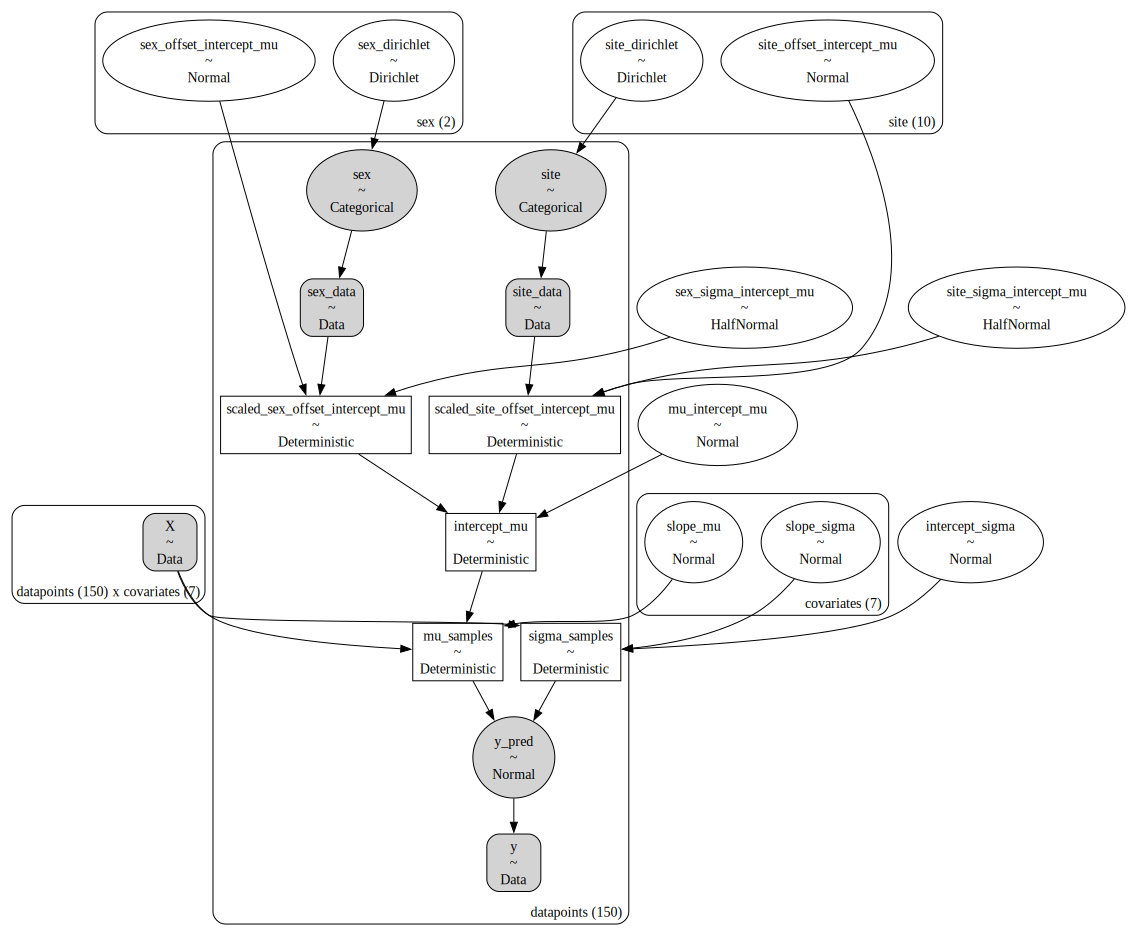

In [60]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


In [61]:
idata = model.idata  # type: ignore
# az.style.use("arviz-doc")
idata

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

Warmup iterations saved (warmup_*).

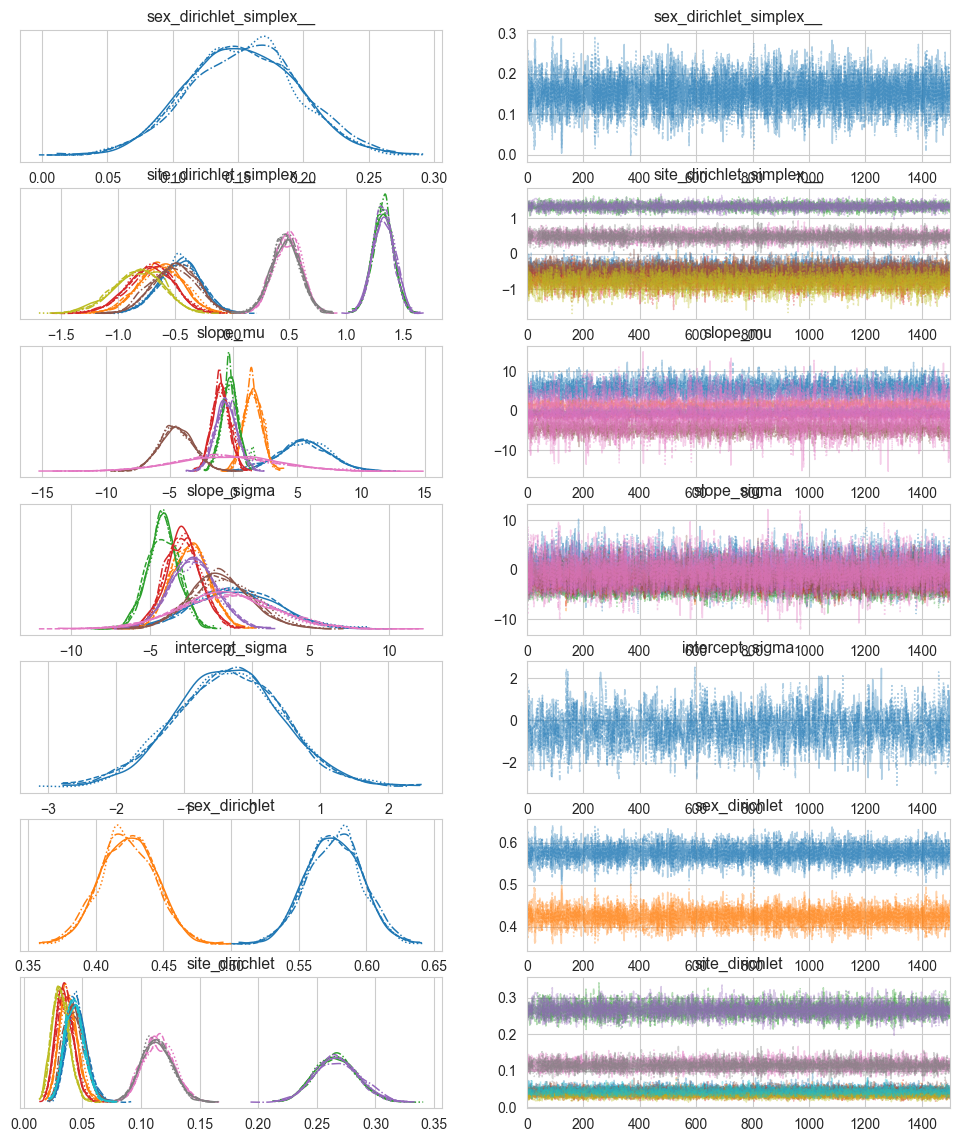

In [62]:
# plt.tight_layout()
az.plot_trace(
    idata.posterior, var_names=["~_samples", "~intercept_mu"], filter_vars="like"
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [63]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.520329,0.394756
RMSE,0.075181,500.196218
SMSE,0.581039,0.767170
ExpV,0.419494,0.241228
NLL,NaN,NaN
ShapiroW,0.992611,0.973620


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [64]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
124,0.619556,1.017402
48,-0.413296,-0.628268
545,0.315505,0.215881
847,1.152411,0.439477
360,-2.138751,-0.382345
...,...,...
688,-1.163066,0.095843
420,0.691020,1.082115
123,-0.844704,-1.229083


In [89]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
124                             2.373530         413.821884   
48                              2.324034         318.710761   
545                             2.325622        -481.519768   
847                             2.360687         444.816670   
360                             2.358375         775.402368   
...                                  ...                ...   
688                             2.331933         322.273912   
420                             2.384972         648.885628   
123                             2.396295         606.374804   
276                             2.423316         102.272916   
183                             2.386696         436.347697   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
124                             2.439515         765.220334   
48                              2.390018         670.109211   
545                             2.414969         754.031249   
847                             2.425203         864.606558   
360                             2.424360        1126.800818   
...                                  ...                ...   
688                             2.398292         799.579206   
420                             2.456863         976.057549   
123                             2.463992         942.937404   
276                             2.487665         500.824052   
183                             2.454393         772.910298   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
124                             2.485381        1009.473710   
48                              2.435884         914.362587   
545                             2.477072        1612.849799   
847                             2.470048        1156.398105   
360                             2.470225        1371.054194   
...                                  ...                ...   
688                             2.444416        1131.349109   
420                             2.506834        1203.471320   
123                             2.511047        1176.878537   
276                             2.532394         777.852765   
183                             2.501449        1006.851430   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
124                             2.531246        1253.727086   
48                              2.481749        1158.615963   
545                             2.539176        2471.668348   
847                             2.514893        1448.189652   
360                             2.516090        1615.307570   
...                                  ...                ...   
688                             2.490541        1463.119012   
420                             2.556805        1430.885090   
123                             2.558103        1410.819669   
276                             2.577123        1054.881478   
183                             2.548504        1240.792563   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


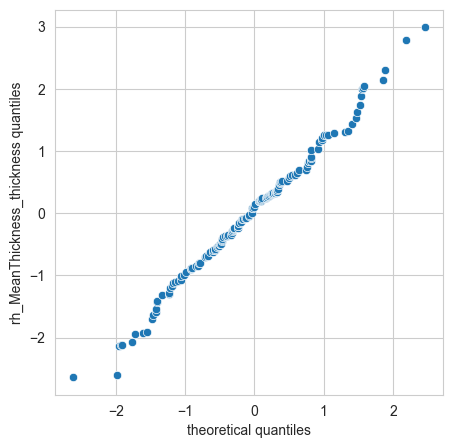

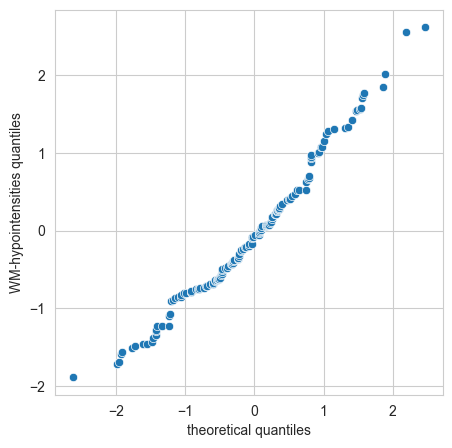

In [90]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

In [91]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
    batch_effects={"site": ["AnnArbor_a"]},
)

AssertionError: AnnArbor_a is not a known value for batch effect dimension site

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


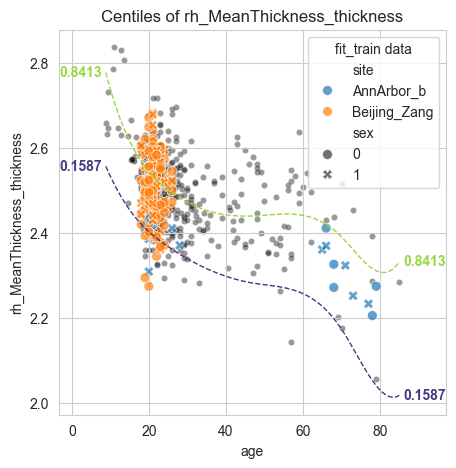

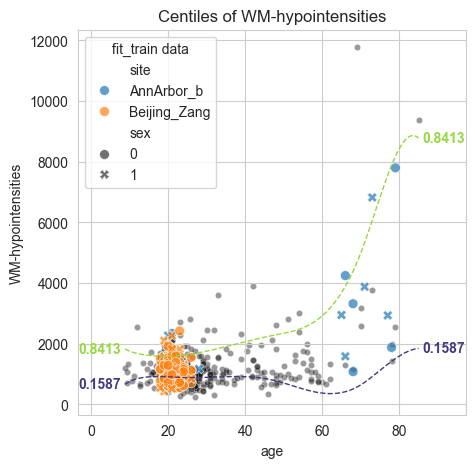

In [95]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["AnnArbor_b", "Beijing_Zang"]},
)

### Getting posterior predictive samples


In [69]:
with model.pymc_model:
    post_pred = pm.sample_posterior_predictive(model.idata.posterior)

post_pred


Sampling: [sex, site, y_pred]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

## Transfer

We transfer the model to the transfer_train dataset that we created before. The posterior distribution is factorized and a new RegConf is created using the factorized posterior as a prior. To give some extra control, we let the `freedom` parameter control the variance of the derived factorized posterior. With a `freedom` of 1, the factorized representation is used as is. With freedom of `2`, all derived prior distributions are widened by a factor of 2. 

In [70]:
transfered_model = norm_hbr.transfer(
    transfer_train, freedom=0.0001, nuts_sampler="nutpie"
)
# Caused by:
#     Logp function returned error: Logp function returned error code 4

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.52,7
,2000,0,0.49,7
,2000,0,0.58,7
,2000,0,0.57,7


Transferring model for WM-hypointensities


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.53,7
,2000,0,0.54,7
,2000,0,0.57,7
,2000,0,0.54,7


Configuration of normative model is valid.
45785 Saving model to resources/hbr/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path

In [71]:
transfered_model.save()

45785 Saving model to resources/hbr/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model


In [72]:
os.makedirs("resources/save_dir_transfer", exist_ok=True)

In [73]:
# transfered_model = load_normative_model("resources/hbr/save_dir_transfer")
transfered_predictions = transfered_model.predict(transfer_test)

Sampling: [y_pred]


Output()

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/plots


In [74]:
display(transfered_predictions.measures.to_pandas().T)
display(transfered_predictions.zscores.to_pandas())
display(
    transfered_predictions.centiles.to_dataframe().unstack(
        level=["response_vars", "cdf"]
    )
)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.755278,0.192813
RMSE,0.066395,443.203831
SMSE,0.583221,0.942733
ExpV,0.504512,0.188220
NLL,NaN,NaN
ShapiroW,0.973392,0.976718


response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
794,-0.542076,0.836535
796,0.579086,0.460316
758,0.428830,2.191895
786,2.601037,0.967244
746,-1.140999,0.395150
749,0.442066,0.080013
802,-0.819763,-0.821403
812,0.781415,-0.163154
730,-0.295686,0.803296


centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
794                             2.405319         427.164404   
796                             2.398576         416.073498   
758                             2.398576         416.072985   
786                             2.412482         436.941246   
746                             2.405319         427.163891   
749                             2.398576         416.073498   
802                             2.398576         416.073498   
812                             2.398576         416.073498   
730                             2.398576         416.072985   
640                             2.294024         201.975926   
607                             2.277564        -190.248967   
731                             2.398576         416.073498   
641                             2.219987        -910.999848   
750                             2.398576         416.073498   
638                             2.262408        -572.831553   
619                             2.286654          89.083743   
826                             2.405319         427.164404   
808                             2.405319         427.164404   
740                             2.405319         427.163891   
626                             2.248762        -741.718341   
807                             2.405319         427.164404   
800                             2.405319         427.163891   
608                             2.228531        -876.017007   
613                             2.294024         201.976439   
774                             2.398576         416.073498   
599                             2.284643          41.031139   
747                             2.405319         427.163891   
816                             2.398576         416.072985   
751                             2.405319         427.163891   
819                             2.405319         427.164404   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
794                             2.472977         763.526288   
796                             2.465287         759.258068   
758                             2.465287         759.257555   
786                             2.481288         768.033491   
746                             2.472977         763.525775   
749                             2.465287         759.258068   
802                             2.465287         759.258068   
812                             2.465287         759.258068   
730                             2.465287         759.257555   
640                             2.367626         836.646596   
607                             2.358442         665.941838   
731                             2.465287         759.258068   
641                             2.315311         678.146395   
750                             2.465287         759.258068   
638                             2.348982         542.387777   
619                             2.363052         794.613431   
826                             2.472977         763.526288   
808                             2.472977         763.526288   
740                             2.472977         763.525775   
626                             2.338683         548.726007   
807                             2.472977         763.526288   
800                             2.472977         763.525775   
608                             2.322380         630.450867   
613                             2.367626         836.647108   
774                             2.465287         759.258068   
599                             2.361952         773.094600   

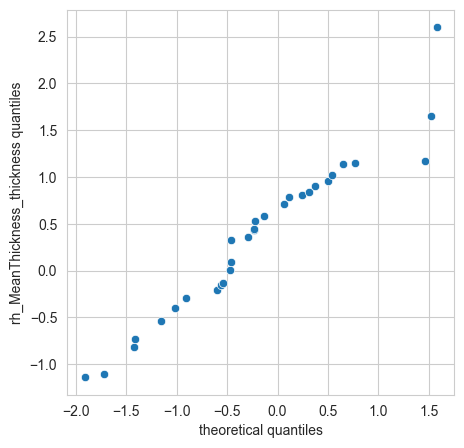

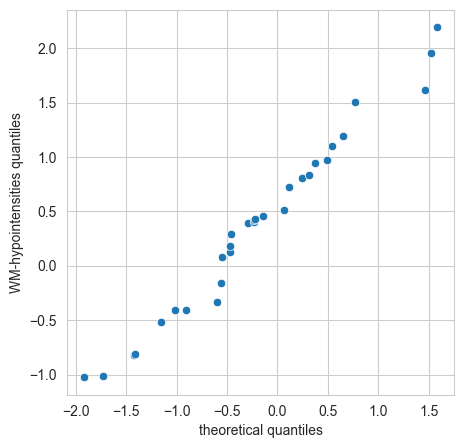

In [75]:
plot_qq(transfer_test)

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


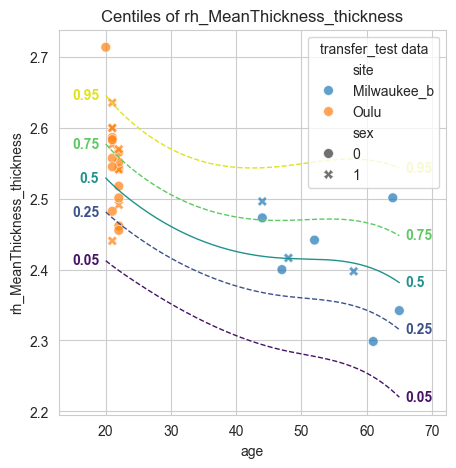

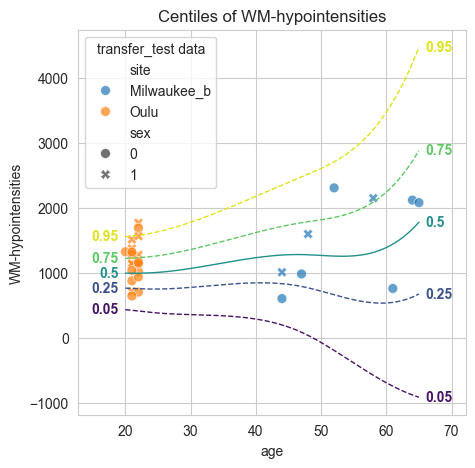

In [97]:
plot_centiles(
    transfered_model,
    transfer_test,
    covariate="age",
    show_data=True,
    batch_effects={"site": ["Milwaukee_b", "Oulu"]},
)


And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!

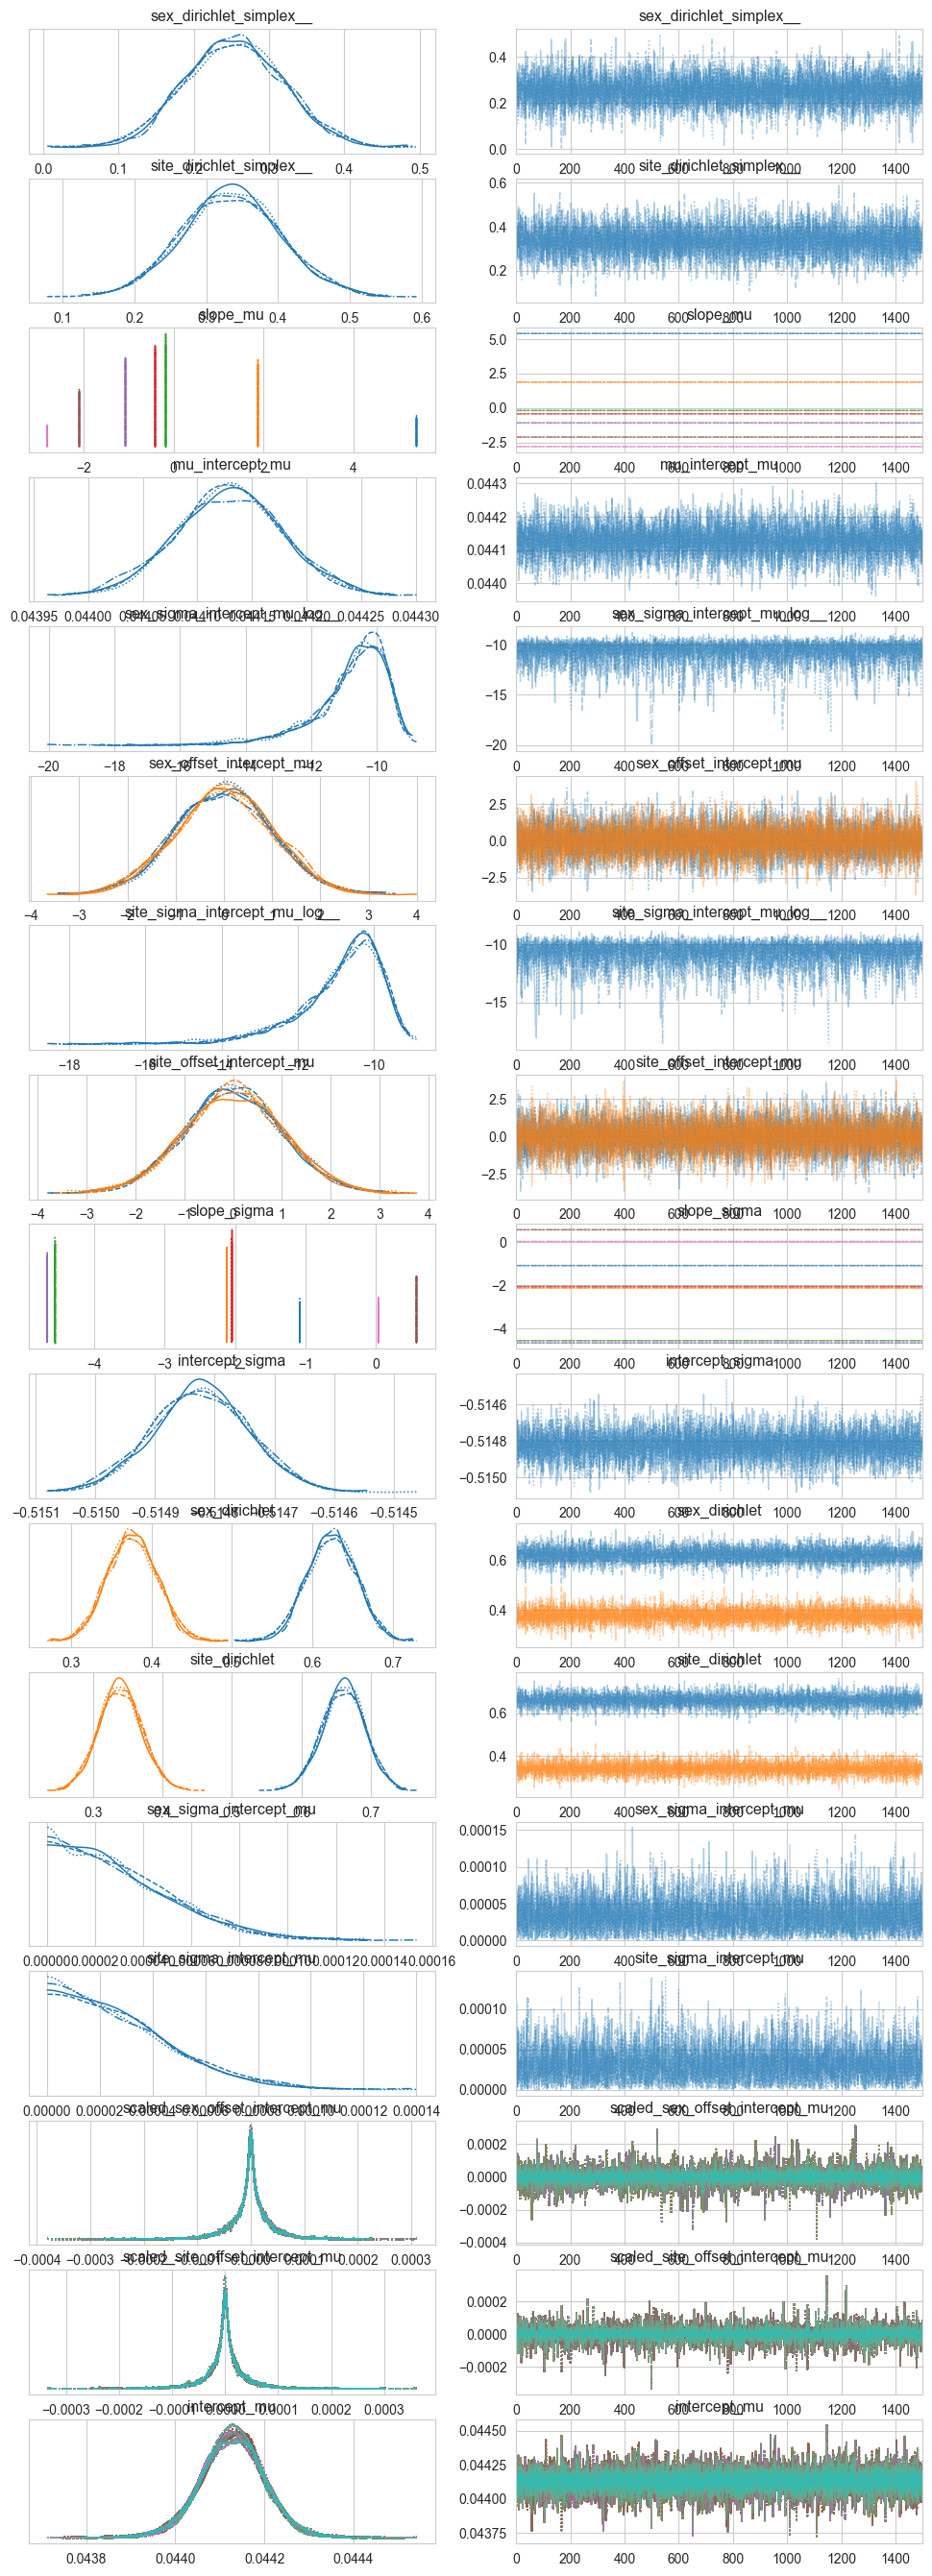

In [43]:
model = transfered_model.regression_models.get("rh_MeanThickness_thickness")
model.pymc_model.to_graphviz()
idata = model.idata  # type: ignore
az.plot_trace(idata.posterior, var_names=["~_samples"], filter_vars="like")
plt.show()